In [12]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy import stats

## Models

In [2]:
def sigmoid(scores):
    predictions = np.zeros(len(scores))
    for i in range(len(predictions)):
        if scores[i] >= 0:
            predictions[i] +=  1.0 / (1.0 + np.exp(-scores[i]))
        else:
            predictions[i] += np.exp(scores[i]) / (1.0 + np.exp(scores[i]))
    return predictions

def lr(trainingSet, testSet):
    #print len(trainingSet.columns)
    regularization = 0.01
    step_size = 0.01
    
    max_iterations = 500
    tol = 1e-6
    
    count = 0
    
    train_labels = trainingSet['decision']    
    trainingSet = trainingSet.drop('decision', axis=1)
    
    #print train_labels, trainingSet
    w = np.zeros(len(trainingSet.columns) + 1)
    
    # Add intercept
    X = np.array(trainingSet)
    Y = np.array(train_labels)
    intercept = np.ones((X.shape[0], 1))
    #X = np.concatenate((X, intercept.T), axis=1)
    X = np.hstack((X, intercept))
    diff = 100.0
    
    while(count < max_iterations and diff > tol):
        count += 1
        norm_old = np.linalg.norm(w)
        
        scores = np.dot(X, w)
        predictions = sigmoid(scores)

        gradient = np.dot(X.T, (predictions - Y))

        for j in range(len(w)):
            gradient[j] += regularization * w[j]
            
        #gradient /= len(train_labels)
        w -= step_size * gradient
        norm_new = np.linalg.norm(w)
        
        diff = abs(norm_new - norm_old)
        #print w
        #print count, diff
    
    return w

def svm(trainingSet, testSet):
    #print len(trainingSet.columns)
    regularization = 0.01
    step_size = 0.50
    
    max_iterations = 500
    tol = 1e-6
    #print len(trainingSet[trainingSet['decision'] == 1])
    count = 0
    train_labels = trainingSet['decision']    
    trainingSet = trainingSet.drop('decision', axis=1)

    w = np.zeros(len(trainingSet.columns) + 1)
    
    # Add intercept
    X = np.array(trainingSet)
    Y = np.array(train_labels)
    #print train_labels
    for i in range(len(Y)):
        if Y[i] == 0:
            Y[i] = -1.0
        else:
            Y[i] = 1.0
    #print Y.tolist()
    intercept = np.ones((X.shape[0], 1))
    X = np.hstack((intercept, X))
    diff = 100.0
    while(count < max_iterations and diff > tol):
        count += 1
        norm_old = np.linalg.norm(w)
        
        predictions = np.dot(X, w)
    
        error = 0
        gradient = np.zeros(len(w))
        for i in range(len(predictions)):
            if predictions[i] * Y[i] < 1.0:
                error += 1
                #gradient -= 1.0 * Y[i] * X[i]
                gradient -= np.multiply(X[i], Y[i])
            
        gradient /= 1.0 * len(train_labels)
        #print gradient.shape, X[0].shape
        
        for j in range(1, len(gradient)):
            gradient[j] += 1.0 * regularization * w[j]

        w -= 1.0 * step_size * gradient
        norm_new = np.linalg.norm(w)
        diff = abs(norm_new - norm_old)
        #print count, diff, error
    #print w
    return w

def nbc(trainingSet, testSet):
    attr_list = list(trainingSet[trainingSet.columns.difference(['decision'])])
    dict_table ={}
    
    # Labels
    dict_labels = {}
    dict_labels['no'] = len(trainingSet[trainingSet['decision'] == 0])
    dict_labels['yes'] = len(trainingSet[trainingSet['decision'] == 1])
    dict_table['decision'] = dict_labels
    
    # Attributes in discrete_columns
    for attr in attr_list:
        dict_attr = {}
        attr_bin = max(int(trainingSet[attr].max()), int(testSet[attr].max()))
        
        dict_attr['no'] = [0 for i in range(attr_bin + 1)]
        dict_attr['yes'] = [0 for i in range(attr_bin + 1)]
        
        for i in range(attr_bin+1):
            dict_attr['no'][i] += len(trainingSet[(trainingSet[attr] == i) & (trainingSet['decision'] == 0)])
            dict_attr['yes'][i] += len(trainingSet[(trainingSet[attr] == i) & (trainingSet['decision'] == 1)])

        dict_table[attr] = dict_attr
        
    return dict_table

## Test

In [3]:
def get_accuracy_lr(w, trainingSet, testSet):
    total_train = len(trainingSet)
    count_train = 0
    total_test = len(testSet)
    count_test = 0
    
    train_labels = trainingSet['decision']
    test_labels = np.array(testSet['decision'])
    #print test_labels
    
    trainingSet = trainingSet.drop('decision', axis=1)
    testSet = testSet.drop('decision', axis=1)
    
    # Test accuracy
    X = np.array(testSet)
    Y = np.array(test_labels)
    intercept = np.ones((X.shape[0], 1))
    X = np.hstack((X, intercept))

    scores = np.dot(X, w)
    predictions = sigmoid(scores)

    for i in range(len(predictions)):
        if predictions[i] > 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0

    for i in range(len(predictions)):    
        if predictions[i] == int(Y[i]):
            count_test += 1
            
    test_accuracy = 1.0 * count_test/total_test
    print 'Test Accuracy LR:', '%.2f' % test_accuracy
    return test_accuracy
    
def get_accuracy_svm(w, trainingSet, testSet):
    total_train = len(trainingSet)
    count_train = 0
    total_test = len(testSet)
    count_test = 0
    
    train_labels = trainingSet['decision']
    test_labels = testSet['decision']
    
    trainingSet = trainingSet.drop('decision', axis=1)
    testSet = testSet.drop('decision', axis=1)
    
    # Test accuracy
    X = np.array(testSet)
    Y = np.array(test_labels)
    intercept = np.ones((X.shape[0], 1))
    X = np.hstack((intercept, X))

    predictions = np.dot(X, w)

    for i in range(len(predictions)):
        if predictions[i] > 0.0:
            predictions[i] = 1
        else:
            predictions[i] = 0

    for i in range(len(predictions)):    
        if predictions[i] == int(Y[i]):
            count_test += 1
            
    test_accuracy = 1.0 * count_test/total_test
    print 'Test Accuracy SVM:', '%.2f' % test_accuracy
    return test_accuracy

def get_accuracy_nbc(dict_table, trainingSet, testSet):
    # Accuracy on training data
    (row, col) = trainingSet.shape
    attr_list = list(trainingSet[trainingSet.columns.difference(['decision'])])
    
    neg_num = len(trainingSet[trainingSet['decision'] == 0])
    pos_num = len(trainingSet[trainingSet['decision'] == 1])
    
    # Accuracy on test data
    (row_test, col_test) = testSet.shape
    
    row_index_test = testSet.index.tolist()

    correct = 0
    for i in row_index_test:
        pd_pos = 1.0 * dict_table['decision']['yes']/row
        pd_neg = 1.0 * dict_table['decision']['no']/row
        #print pd_pos, pd_neg
        for attr in attr_list:
            pd_pos *= 1.0 * dict_table[attr]['yes'][int(testSet[attr][i])]/pos_num
            pd_neg *= 1.0 * dict_table[attr]['no'][int(testSet[attr][i])]/neg_num
        
        res = np.argmax([1.0 * pd_neg, 1.0 * pd_pos])
        if res == testSet['decision'][i]:
            correct += 1
    test_accuracy = 1.0 * correct/row_test
    print 'Test Accuracy NBC:', '%.2f' % test_accuracy
    return test_accuracy

In [4]:
def get_binned_data(bin_value):
    df = pd.read_csv('dating-full.csv').head(6500)
    #df = pd.head(6500)
    (row, col) = df.shape

    # strip
    df['race'] = df['race'].str.replace("'","")
    df['race_o'] = df['race_o'].str.replace("'","")
    df['field'] = df['field'].str.replace("'","")
    
    # lower case
    df['field'] = df['field'].str.lower()
    
    # gender
    df['gender'] = df['gender'].astype('category')
    df['gender'] = df['gender'].cat.codes    
    # race
    df['race'] = df['race'].astype('category')
    df['race'] = df['race'].cat.codes
    #print d['race']    
    # race_o
    df['race_o'] = df['race_o'].astype('category')
    df['race_o'] = df['race_o'].cat.codes    
    # field
    df['field'] = df['field'].astype('category')
    df['field'] = df['field'].cat.codes
    
    # Normalize the score
    preference_scores_of_participant  = \
    ['attractive_important', 'sincere_important', 'intelligence_important',\
     'funny_important', 'ambition_important', 'shared_interests_important']

    preference_scores_of_partner = \
    ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', \
     'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']

    for i in range(row):
        participant_sum = 0
        partner_sum = 0
    
        for pref in preference_scores_of_participant:
            participant_sum += df[pref][i]
            
        for pref in preference_scores_of_partner:
            partner_sum += df[pref][i]
        
        # update the preference scores of participant
        for pref in preference_scores_of_participant:
            df.loc[i, pref] = df[pref][i]/participant_sum
            
        # update the preference scores of partner
        for pref in preference_scores_of_partner:
            df.loc[i, pref] = df[pref][i]/partner_sum
        
    discrete_columns = ['gender', 'race', 'race_o', 'samerace', 'field', 'decision']
    all_columns = df.columns.values.tolist()
    continuous_valued_columns = [item for item in all_columns if item not in discrete_columns]

    (row, col) = df.shape
    age_range = [18.0, 58.0]
    pref_score = [0.0, 1.0]
    score = [0.0, 10.0]
    corr_range = [-1.00, 1.00]
    
    bin_seg = [1.000 * i/bin_value for i in range(0, bin_value + 1)]
    #print bin_seg

    age = ['age', 'age_o']
    corr = ['interests_correlate']
    preference_scores_of_participant = \
    ['attractive_important', 'sincere_important', 'intelligence_important',\
     'funny_important', 'ambition_important', 'shared_interests_important']
    
    preference_scores_of_partner = \
    ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', \
     'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']
    
    continuous_valued_columns_bins = {}
    
    # Segment the bins
    for field in continuous_valued_columns:
        continuous_valued_columns_bins[field] = []
        if field in age:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(age_range[0] + bin_seg[i] * (age_range[1] - age_range[0]))
        elif field in corr:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(corr_range[0] + bin_seg[i] * (corr_range[1] - corr_range[0]))
        elif field in preference_scores_of_participant or field in preference_scores_of_partner:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(pref_score[0] + bin_seg[i] * (pref_score[1] - pref_score[0]))
        else:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(score[0] + bin_seg[i] * (score[1] - score[0]))
    
    # Dictionary of the numbers ine ach bin
    continuous_valued_columns_seg = {}
    # Initalize the dict
    for field in continuous_valued_columns:
        continuous_valued_columns_seg[field] = [0 for i in range(bin_value)]
    
    for i in range(row):
        for field in continuous_valued_columns:
            # Find the bin
            for j in range(0, bin_value):
                # Corner Case
                if j == 0:
                    if continuous_valued_columns_bins[field][j] <= float(df[field][i]) <= continuous_valued_columns_bins[field][j + 1]:
                        df.loc[i,field] = int(j)
                        continuous_valued_columns_seg[field][j] += 1
                        break
                elif j == bin_value - 1:
                    if continuous_valued_columns_bins[field][j] < float(df[field][i]):
                        df.loc[i,field] = int(j)
                        continuous_valued_columns_seg[field][j] += 1
                        break
                else:
                    if continuous_valued_columns_bins[field][j] < float(df[field][i]) <= continuous_valued_columns_bins[field][j + 1]:
                        df.loc[i,field] = int(j)
                        continuous_valued_columns_seg[field][j] += 1
                        break
        
    df = df.astype('int64')
    df_test = df.sample(frac=0.2, random_state=25)    
    # Subtract 
    df_train = df[~df.index.isin(df_test.index)]

    return df_train, df_test

## Run

In [5]:
trainingDataFilename = 'trainingSet.csv'
testDataFilename = 'testSet.csv'
trainingSet = pd.read_csv(trainingDataFilename)
testSet = pd.read_csv(testDataFilename)

trainingSet_nbc, testSet_nbc = get_binned_data(5)

f = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2]

In [6]:
# Sample the training set
trainingSet = trainingSet.sample(frac=1, random_state=18)
trainingSet_nbc = trainingSet_nbc.sample(frac=1, random_state=18)

df_kfold = []
for i in range(10):
    df_kfold.append(trainingSet[i*520:(i+1)*520])
    
df_kfold_nbc = []
for i in range(10):
    df_kfold_nbc.append(trainingSet_nbc[i*520:(i+1)*520])
    
nbc_res = {}
lr_res = {}
svm_res = {}

for t_frac in f:
    nbc_res[t_frac] = []
    lr_res[t_frac] = []
    svm_res[t_frac] = []
#print nbc

In [7]:
for t_frac in f:
    print 'f =' , t_frac
    for i in range(10):
        # Partition the tarin and cv
        train_set_df = []
        train_set_nbc_df = []
        
        for j in range(10):
            if j != i:
                train_set_df.append(df_kfold[j])
                train_set_nbc_df.append(df_kfold_nbc[j])
            else:
                test_set = df_kfold[j]
                test_set_nbc = df_kfold_nbc[j]
        
        train_set = pd.concat(train_set_df).sample(frac=t_frac, random_state=32)
        train_set_nbc = pd.concat(train_set_nbc_df).sample(frac=t_frac, random_state=32)
        #print train_set
        
        # Train and Test
        w = lr(train_set, test_set)
        lr_res[t_frac].append(get_accuracy_lr(w, train_set, test_set))

        w = svm(train_set, test_set)
        svm_res[t_frac].append(get_accuracy_svm(w, train_set, test_set))
        
        dict_nbc = nbc(train_set_nbc, test_set_nbc)
        nbc_res[t_frac].append(get_accuracy_nbc(dict_nbc, train_set_nbc, test_set_nbc))

#print lr_res
#print svm_res
#print nbc_res

f = 0.025
Test Accuracy LR: 0.67
Test Accuracy SVM: 0.59
Test Accuracy NBC: 0.61
Test Accuracy LR: 0.72
Test Accuracy SVM: 0.65
Test Accuracy NBC: 0.62
Test Accuracy LR: 0.68
Test Accuracy SVM: 0.52
Test Accuracy NBC: 0.62
Test Accuracy LR: 0.69
Test Accuracy SVM: 0.61
Test Accuracy NBC: 0.62
Test Accuracy LR: 0.60
Test Accuracy SVM: 0.56
Test Accuracy NBC: 0.65
Test Accuracy LR: 0.72
Test Accuracy SVM: 0.57
Test Accuracy NBC: 0.58
Test Accuracy LR: 0.58
Test Accuracy SVM: 0.53
Test Accuracy NBC: 0.58
Test Accuracy LR: 0.61
Test Accuracy SVM: 0.51
Test Accuracy NBC: 0.60
Test Accuracy LR: 0.69
Test Accuracy SVM: 0.50
Test Accuracy NBC: 0.59
Test Accuracy LR: 0.59
Test Accuracy SVM: 0.52
Test Accuracy NBC: 0.60
f = 0.05
Test Accuracy LR: 0.62
Test Accuracy SVM: 0.56
Test Accuracy NBC: 0.65
Test Accuracy LR: 0.62
Test Accuracy SVM: 0.48
Test Accuracy NBC: 0.61
Test Accuracy LR: 0.61
Test Accuracy SVM: 0.53
Test Accuracy NBC: 0.64
Test Accuracy LR: 0.68
Test Accuracy SVM: 0.55
Test Accura

## Draw the plots

[0.6540384615384616, 0.6476923076923077, 0.6609615384615385, 0.6819230769230769, 0.6509615384615385, 0.6573076923076921] [0.5567307692307691, 0.5521153846153847, 0.5590384615384615, 0.5655769230769232, 0.5767307692307692, 0.5690384615384615]


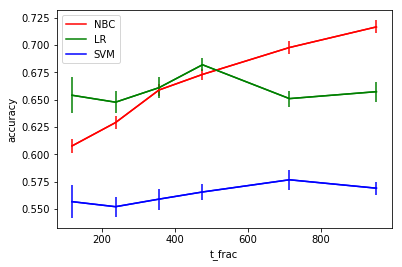

In [18]:
f = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
# Get avg accuracy
nbc_avg = []
lr_avg = []
svm_avg = []

# Get std error
nbc_stdrr = []
lr_stdrr = []
svm_stdrr = []

for i in f:
    nbc_avg.append(np.mean(nbc_res[i], axis = 0))
    nbc_stdrr.append(np.std(nbc_res[i], axis = 0)/np.sqrt(10))
    lr_avg.append(np.mean(lr_res[i], axis = 0))
    lr_stdrr.append(np.std(lr_res[i], axis = 0)/np.sqrt(10))
    svm_avg.append(np.mean(svm_res[i], axis = 0))
    svm_stdrr.append(np.std(svm_res[i], axis = 0)/np.sqrt(10))

for i in range(len(f)):
    f[i] *= 9 * 529

print lr_avg, svm_avg
    
fig = plt.figure()
plt.plot(f, nbc_avg, color='red', label='NBC')
plt.plot(f, lr_avg, color='green', label='LR')
plt.plot(f, svm_avg, color='blue', label='SVM')

plt.errorbar(f, nbc_avg, nbc_stdrr, color='red')
plt.errorbar(f, lr_avg, lr_stdrr, color='green')
plt.errorbar(f, svm_avg, svm_stdrr, color='blue')

plt.xlabel("t_frac")
plt.ylabel("accuracy");
plt.legend()

plt.show()

In [20]:
stats.ttest_ind(lr_avg, svm_avg)

Ttest_indResult(statistic=15.415948619949303, pvalue=2.6874121443687926e-08)

In [19]:
stats.ttest_ind(lr_stdrr, svm_stdrr)

Ttest_indResult(statistic=0.24279884431763557, pvalue=0.8130687604827431)